# Testing Classical Joint Alignment
## Importing Necessary Packages
Import basic packages for tomographic scans, plotting, and image transformation.

In [83]:
# Import packages
import numpy as np
import tomopy
import cv2
import matplotlib.pyplot as plt
from skimage.transform import rotate, AffineTransform
import tifffile

## Creating Phantom Tomography
Creating a phantom which will operate as the ground truth for the realignment of an artificially misaligned version of the phantom.

In [84]:
# Creating ground truth tomography
data = tomopy.shepp3d(256)
ang = tomopy.angles(181)
proj = tomopy.project(data, ang)

## Misalignment Projection
A misalignment axis is randomly determined in order to misalign the projection data artificially. A function is defined to apply the misalignment to the original projection.

In [85]:
# Randomly determined misalignment axis
mis_axis = np.random.normal(0, 1, (200, 3))
mis_axis[:, :1] = mis_axis[:, :1]*4
mis_axis = np.round(mis_axis).astype(int)

In [86]:
# Define function for artificial misalignment
def misalign(prj, mis_axis, ang_tilt = False, noise = False, background = False):
    num_prj, col, row = prj.shape
    prj_tmp = np.zeros_like(prj)
    
    for i in range(num_prj):
        d_row, d_col, d_ang = mis_axis[i]
        
        if ang_tilt == True:
            prj_tmp[i, :, :] = rotate(prj[i,:,:], d_ang)
        else:
            prj_tmp[i, :, :] = prj[i,:,:]
            
        translation_matrix = np.float32([ [1,0,d_row], [0,1,d_col] ])
        prj_tmp[i, :, :] = cv2.warpAffine(prj_tmp[i, :, :], translation_matrix, (row, col))
        
        if noise == True:
            prj_tmp[i, :, :] = random_noise(prj_tmp[i, :, :], mode = 'gaussian')
            
        if background == True:
            prj_tmp[i, :, :] = prj_tmp[i, :, :]+np.random.random()/5
            prj_tmp[i, :, :] = prj_tmp[i, :, :]/prj_tmp[i, :, :].max()
            
    return prj_tmp

In [87]:
# Creating misaligned projections
proj_mis = misalign(proj, mis_axis, ang_tilt = True)

## Realignment
The 'align_joint' method from TomoPy will be used with 100 iterations and the SIRT algorithm for reconstruction in order to create the realignment of the artificially realigned projection.

In [88]:
# Creating realigned projection using joint alignment
proj_align = tomopy.align_joint(proj_mis.copy(), ang, iters = 100, algorithm = 'sirt')

iter=0, err=0.3034613062129118
iter=1, err=0.015926558706428135
iter=2, err=0.006652814800730988
iter=3, err=0.004488419074968821
iter=4, err=0.0034057536435502227
iter=5, err=0.0027624309803899482
iter=6, err=0.0025318098139456018
iter=7, err=0.0018323894142414146
iter=8, err=0.0014617410776184296
iter=9, err=0.001562666943034828
iter=10, err=0.0012353966910606626
iter=11, err=0.0016574585882339688
iter=12, err=0.0013533092703223314
iter=13, err=0.000781333471517414
iter=14, err=0.0013533092703223314
iter=15, err=0.0014617410776184296
iter=16, err=0.000956934162087539
iter=17, err=0.0005524861960779896
iter=18, err=0.0011049723921559792
iter=19, err=0.000956934162087539
iter=20, err=0.000781333471517414
iter=21, err=0.0011049723921559792
iter=22, err=0.0
iter=23, err=0.0
iter=24, err=0.000781333471517414
iter=25, err=0.0011049723921559792
iter=26, err=0.0005524861960779896
iter=27, err=0.0
iter=28, err=0.000956934162087539
iter=29, err=0.0
iter=30, err=0.0005524861960779896
iter=31, e

In [181]:
# Define function for realignment
def realign(prj, x_trans, y_trans):
    # Initialize new projection
    num_prj, col, row = prj.shape
    prj_tmp = np.zeros_like(prj)
    
    # Make the translation for every row
    for i in range(num_prj):
        dx = x_trans[i]
        dy = y_trans[i]
        prj_tmp[i, :, :] = prj[i,:,:]
        translation_matrix = np.float32([ [1,0,dx], [0,1,dy] ])
        prj_tmp[i, :, :] = cv2.warpAffine(prj_tmp[i, :, :], translation_matrix, (row, col))
        
    return prj_tmp

## Analyzing Realignment
Now that the realignment algorithm has been run, use the correction arrays for the x and y direction in order to create modifications to the misaligned array in order to create a realigned array. The actual random changes made by misalignment are plotted with the changes predicted by the algorithm in order to make comparisons.

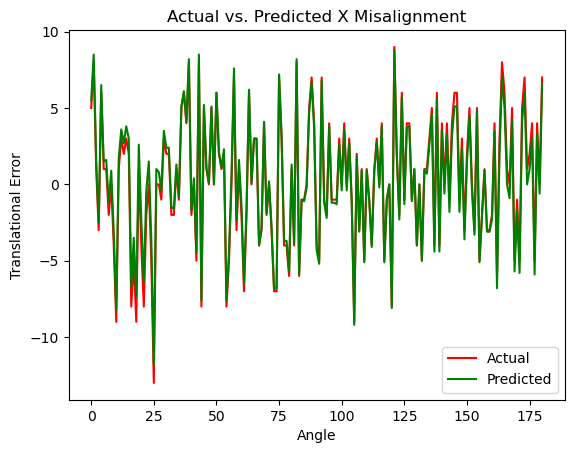

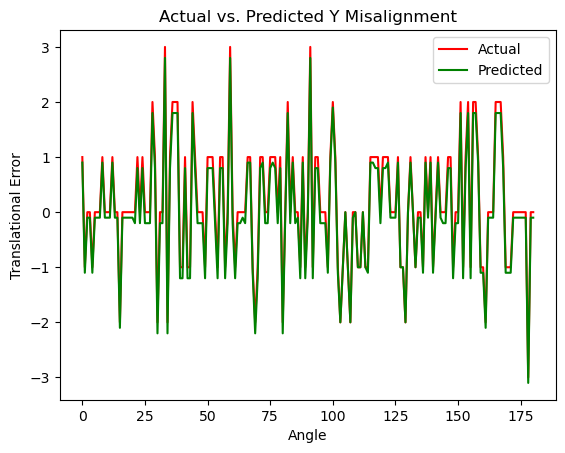

In [182]:
# Apply translations to original
true_x = mis_axis[:181, 0]
true_y = mis_axis[:181, 1]
x_translation = proj_align[2]
y_translation = proj_align[1]

# Create realigned projections
proj_re = realign(proj_mis, -x_translation, -y_translation)

# Plot shows the actual x misalignment vs. predicted
plt.plot(true_x, color = 'r', label = 'Actual')
plt.plot(x_translation, color = 'g', label = 'Predicted')
plt.xlabel("Angle")
plt.ylabel("Translational Error")
plt.title("Actual vs. Predicted X Misalignment")
plt.legend()
plt.show()

# Plot shows the actual x and y misalignment vs. modeled
plt.plot(true_y, color = 'r', label = 'Actual')
plt.plot(y_translation, color = 'g', label = 'Predicted')
plt.xlabel("Angle")
plt.ylabel("Translational Error")
plt.title("Actual vs. Predicted Y Misalignment")
plt.legend()
plt.show()

## Sinogram Analysis
As demonstrated by the graphics, a sample layer has its original, misaligned, and realigned sinograms for analysis. The visuals show that the realignment has mostly corrected the misalignment, with a bit of blurring around some edges.

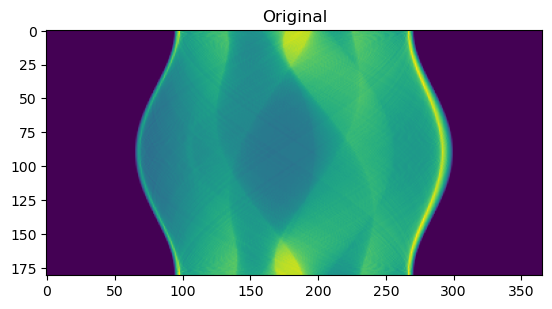

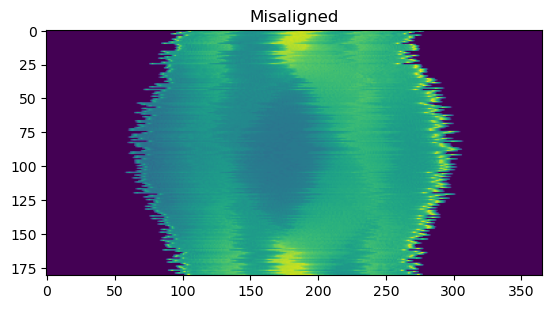

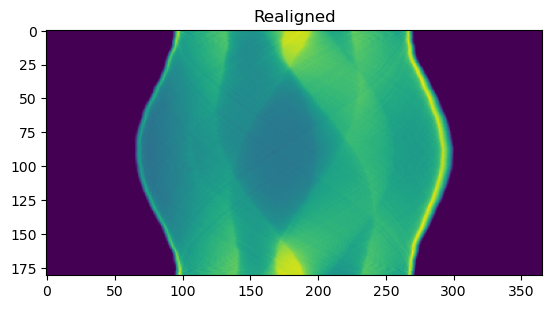

In [186]:
# Sinogram for original
plt.imshow(proj[:, 128, :])
plt.title('Original')
plt.show()

# Sinogram for misaligned
plt.imshow(proj_mis[:, 128, :])
plt.title('Misaligned')
plt.show()

# Sinogram for realigned
plt.imshow(proj_re[:, 128, :])
plt.title('Realigned')
plt.show()

## Reconstruction Analysis
Reconstructions made of the same slice for the original, misaligned, and realigned projections for comparison. The realigned reconstruction is similar to the original, with a bit of artifacting in certain areas.

In [187]:
# Create tomographic reconstructions
recon = tomopy.recon(proj, ang, algorithm='gridrec', sinogram_order=False)
recon_mis = tomopy.recon(proj_mis, ang, algorithm='gridrec', sinogram_order=False)
recon_re = tomopy.recon(proj_re, ang, algorithm='gridrec', sinogram_order=False)

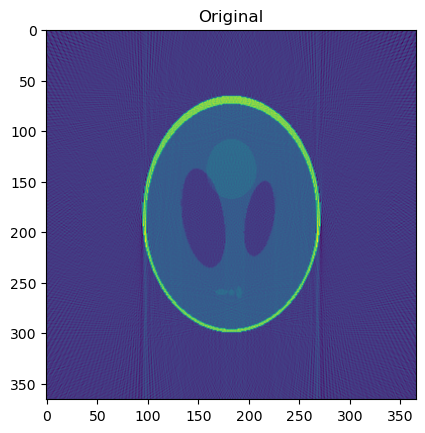

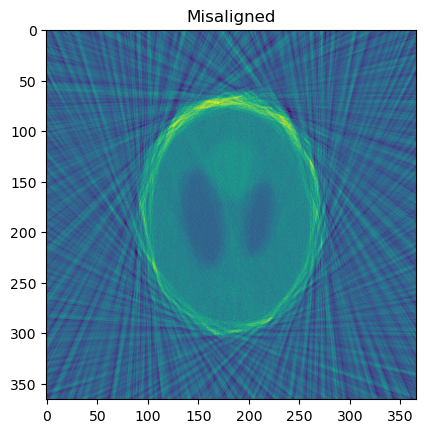

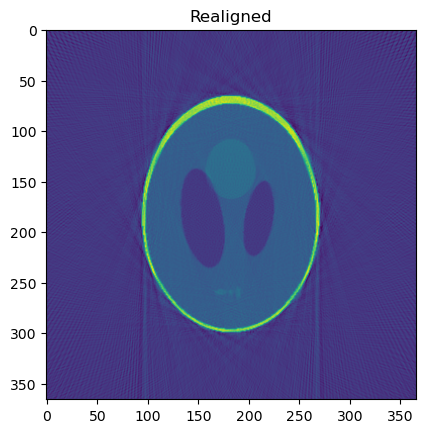

In [188]:
# Reconstruction for original
plt.imshow(recon[128])
plt.title('Original')
plt.show()

# Reconstruction for misaligned
plt.imshow(recon_mis[128])
plt.title('Misaligned')
plt.show()

# Reconstruction for realigned
plt.imshow(recon_re[128])
plt.title('Realigned')
plt.show()